# Self-Driving Car Engineer Nanodegree

## Computer Vision

### Project: Build a pipeline for lane line detection

The code in this notebook implements the steps to detect the lane lines on the road. The comments explain the individual steps.

The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera Calibration

In [6]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Chessboard meta data (horizontal and vertical corners)
chess_corner_hor = 9
chess_corner_ver = 6

# Read in and make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ..., (8,5,0)
objp = np.zeros((chess_corner_ver*chess_corner_hor,3), np.float32)
objp[:,:2] = np.mgrid[0:chess_corner_hor,0:chess_corner_ver].T.reshape(-1,2) # x,y coordinates

for fname in images:
    # read in each image
    img = mpimg.imread(fname)
    # convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chess_corner_hor,chess_corner_ver),None)
    
    # if corners are found, add object points and image points
    if (True == ret):
        imgpoints.append(corners)
        objpoints.append(objp)

# return value, distortion camera matrix, distortion coefficients, rotation and translation vectors
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# end of camera calibration

### Applying camera calibration data - Undistortion

In [7]:
sample_distorted = mpimg.imread(images[12])
sample_undistorted = cv2.undistort(sample_distorted, mtx, dist, None, mtx)

#### Distorted image example

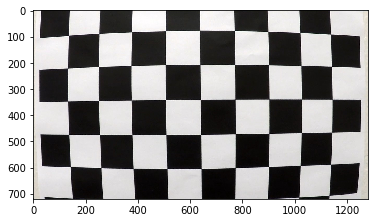

In [10]:
_ = plt.imshow(sample_distorted)

#### Undistorted image example

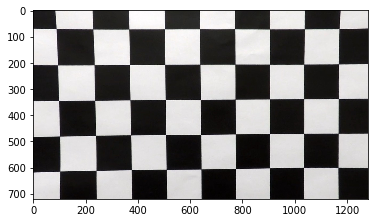

In [11]:
_ = plt.imshow(sample_undistorted)